In [2]:
import bayes3d as b3d
import genjax
from genjax import gen, choice_map, vector_choice_map
import jax
from jax import jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import trimesh
from bayes3d._mkl.utils import *
from bayes3d._mkl.importance import _importance_sampling
from functools import partial

key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

In [3]:
from bayes3d._mkl.pose import pack_pose, unpack_pose, apply_pose, lift_pose
from bayes3d._mkl.meshes import *
from bayes3d._mkl.plotting import *

fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts  = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T      = len(_xs)
_segs   = _segs.reshape(-1,2,2)
_boxes  = _boxes.reshape(-1,2,2)
_bb     = bounding_box(_segs)
_ps     = np.concatenate([_xs, _hds[:,None]], axis=1)

_T

50

In [4]:
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs.reshape(-1,4))
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)
map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2]    -= 0.5

Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)
['object_0', 'object_1']


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


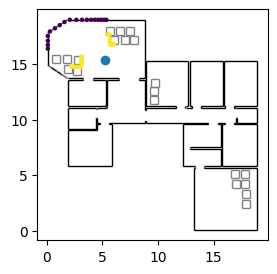

In [66]:
w = 50
h = 1

near = 0.01
far  = 10.0

fx = 10
fy = 10

cx = w/2 - 0.5
cy = h/2 - 0.5

intrinsics = b3d.Intrinsics(
    height = h,
    width  = w,
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    near=near, far=far
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)

def render(p, inds=[0,1]):
    p_ = b3d.t3d.inverse_pose(p)
    return b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))

print(b3d.RENDERER.mesh_names)

t = 40
p = _ps[t]
X = render(lift_pose(p[:2], p[2]), inds=[0,1])
xs = X[0][:,[0,2]]
xs = apply_2dpose(p, xs)

# -----------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(plt.gca(),_segs, c="k", zorder=-1)
plot_segs(plt.gca(),_boxes, c="gray", zorder=-1)
plt.scatter(*_ps[t][:2], marker="o")
plt.scatter(*xs.T,c=X[0,:,3], vmin=1, vmax=2, s=5)

In [67]:
@genjax.gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd)             @ "hd"
    
    return pack_2dpose(x, adjust_angle(hd))

In [68]:
keysplit(key)

Array([2806430990, 3511999563], dtype=uint32)

(101, 3) [ 5.2565    15.3676195  2.2455373] [ 5.2565     15.36761905  2.24553727]
[[ 5.2565    15.3676195  2.2455373]
 [ 5.5471582 15.04617    2.0355012]]


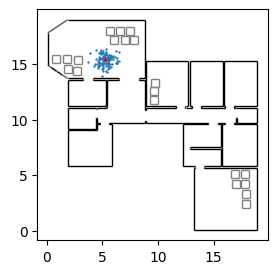

In [69]:
t = 40
p0 = _ps[t]
key, keys = keysplit(key, 1, 100)
qs = vmap(anchored_pose_prior(p0, sig_x=0.5, sig_hd=15))(keys)
qs = jnp.concatenate([p0[None], qs], axis=0)

print(qs.shape, qs[0], p0)
print(qs[:2])

# -----------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(plt.gca(),_segs, c="k", zorder=-1)
plot_segs(plt.gca(),_boxes, c="gray", zorder=-1)
plt.scatter(*qs[:,:2].T, marker=".", s=2, c="C0")
plt.scatter(*p0[:2], marker=".", s=10, c="r")

In [62]:
Xs = []
Ys = []
for q in qs:
    Xs.append(render(lift_pose(q[:2], q[2]), inds=[0,1]))
    Ys.append(render(lift_pose(q[:2], q[2]), inds=[0]))

Xs = jnp.stack(Xs)    
Ys = jnp.stack(Ys)    


In [65]:
suff = f"{Xs[0].shape[0]}x{Xs[0].shape[1]}"
jnp.save(f"./data/test_Xs_{suff}", Xs)
jnp.save(f"./data/test_Ys_{suff}", Ys)
jnp.save(f"./data/test_ps_{suff}", qs)

## 3D

Increasing frame buffer size to (width, height, depth) = (128, 64, 1024)
['object_0', 'object_1']


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


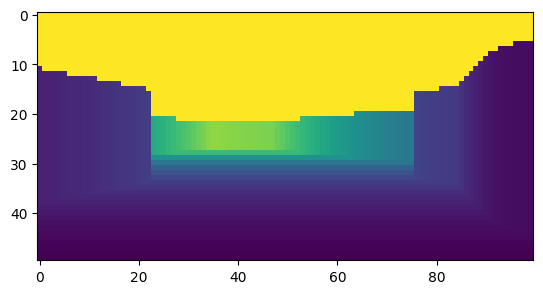

In [104]:
w = 100
h = 50

near = 0.01
far  = 10.0

fx = 30
fy = 30

cx = w/2 - 0.5
cy = h/2 - 0.5

intrinsics = b3d.Intrinsics(
    height = h,
    width  = w,
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    near=near, far=far
)
b3d.setup_renderer(intrinsics)
b3d.RENDERER.add_mesh(trimesh.util.concatenate([map_mesh, table]), center_mesh=False)
b3d.RENDERER.add_mesh(box_mesh, center_mesh=False)

def render(p, inds=[0,1]):
    p_ = b3d.t3d.inverse_pose(p)
    return b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))

print(b3d.RENDERER.mesh_names)

t = 40
p = _ps[t]
X = render(lift_pose(p[:2], p[2]), inds=[0,1])
xs = X[0][:,[0,2]]
xs = apply_2dpose(p, xs)


plt.imshow(X[:,:,2], vmax=6.)

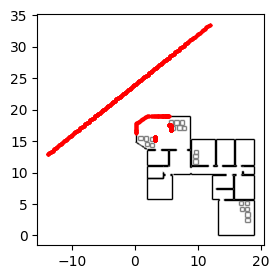

In [105]:
xs = X[:h//2,:,[0,2]]
xs = apply_2dpose(p, xs)

# -----------------
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(plt.gca(),_segs, c="k", zorder=-1)
plot_segs(plt.gca(),_boxes, c="gray", zorder=-1)
plt.scatter(*xs.T, marker=".", s=10, c="r")

In [106]:
Xs = []
Ys = []
for q in qs:
    Xs.append(render(lift_pose(q[:2], q[2]), inds=[0,1]))
    Ys.append(render(lift_pose(q[:2], q[2]), inds=[0]))

Xs = jnp.stack(Xs)    
Ys = jnp.stack(Ys)    

suff = f"{Xs[0].shape[0]}x{Xs[0].shape[1]}"
jnp.save(f"./data/test_Xs_{suff}", Xs)
jnp.save(f"./data/test_Ys_{suff}", Ys)
jnp.save(f"./data/test_ps_{suff}", qs)